## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Skyno\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Skyno\Anaco

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
def build_mlp3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [19]:
def build_mlp4(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    input_layer = BatchNormalization(input_layer)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
    
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)

            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [64, 128, 256]
MOMENTUM = 0.95

In [10]:
results = {}

for batch_size in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "batch_size-%s" % str(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.7343 - acc: 0.3920 - val_loss: 1.6171 - val_acc: 0.4268
Epoch 2/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.4992 - acc: 0.4694 - val_loss: 1.5835 - val_acc: 0.4406
Epoch 3/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.4084 - acc: 0.5061 - val_loss: 1.4890 - val_acc: 0.4749
Epoch 4/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.3488 - acc: 0.5221 - val_loss: 1.4936 - val_acc: 0.4650
Epoch 5/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.2916 - acc: 0.5449 - val_loss: 1.5699 - val_acc: 0.4405
Epoch 6/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2531 - acc: 0.5567 - val_loss: 1.4351 - val_acc: 0.4921
Epoch 7/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.2213 - acc: 0.5682 - val_loss: 1.5018 - 

50000/50000 [==============================] - 3s 52us/step - loss: 0.8318 - acc: 0.7149 - val_loss: 1.6526 - val_acc: 0.4680
Epoch 19/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.7969 - acc: 0.7299 - val_loss: 1.5617 - val_acc: 0.4950
Epoch 20/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7706 - acc: 0.7371 - val_loss: 1.5707 - val_acc: 0.4801
Epoch 21/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.7418 - acc: 0.7465 - val_loss: 1.6299 - val_acc: 0.4879
Epoch 22/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.7080 - acc: 0.7604 - val_loss: 1.6250 - val_acc: 0.4787
Epoch 23/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.6810 - acc: 0.7711 - val_loss: 1.6686 - val_acc: 0.4784
Epoch 24/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.6467 - acc: 0.7825 - val_loss: 1.7817 - val_acc: 0.4697
Epoch 25/50
50000/50000 [=====================

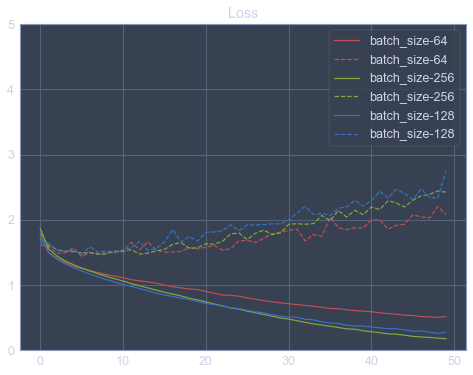

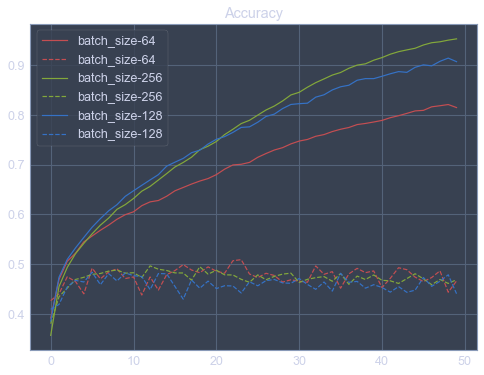

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

fig = plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()
fig.savefig("BN_loss.png", bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
fig.savefig("BN_acc.png", bbox_inches='tight', dpi=300)

In [13]:
model = build_mlp2(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=128, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 69us/step - loss: 1.9

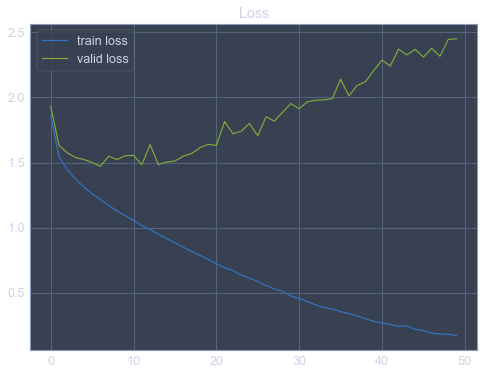

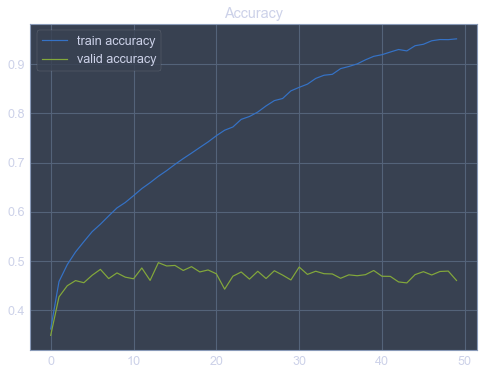

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()
fig.savefig("loss.png", bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()
fig.savefig("acc.png", bbox_inches='tight', dpi=300)


In [17]:
results2 = {}

for batch_size in BATCH_SIZE:
    model = build_mlp3(input_shape=x_train.shape[1:])
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "batch_size-%s" % str(batch_size)
    results2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.7042 - acc: 0.3992 - val_loss: 1.9317 - val_acc: 0.3444
Epoch 2/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.4758 - acc: 0.4793 - val_loss: 1.6051 - val_acc: 0.4366
Epoch 3/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.3860 - acc: 0.5099 - val_loss: 1.5892 - val_acc: 0.4371
Epoch 4/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.3257 - acc: 0.5320 - val_loss: 1.5336 - val_acc: 0.4617
Epoch 5/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.2681 - acc: 0.5540 - val_loss: 1.6393 - val_acc: 0.4367
Epoch 6/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.2268 - acc: 0.5658 - val_loss: 1.4695 - val_acc: 0.4791
Epoch 7/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.1849 - acc: 0.5813 - val_loss: 1.6056 - 

50000/50000 [==============================] - 3s 52us/step - loss: 0.8576 - acc: 0.7059 - val_loss: 1.4662 - val_acc: 0.4991
Epoch 19/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.8280 - acc: 0.7194 - val_loss: 1.4437 - val_acc: 0.5100
Epoch 20/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.7941 - acc: 0.7302 - val_loss: 1.6020 - val_acc: 0.4692
Epoch 21/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.7743 - acc: 0.7379 - val_loss: 1.5751 - val_acc: 0.4915
Epoch 22/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.7458 - acc: 0.7488 - val_loss: 1.5439 - val_acc: 0.4952
Epoch 23/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7138 - acc: 0.7619 - val_loss: 1.5907 - val_acc: 0.4832
Epoch 24/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.6931 - acc: 0.7678 - val_loss: 1.5840 - val_acc: 0.4962
Epoch 25/50
50000/50000 [=====================

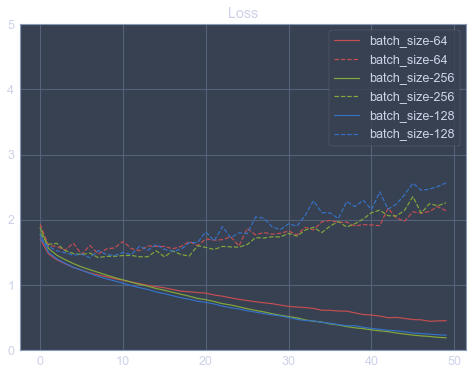

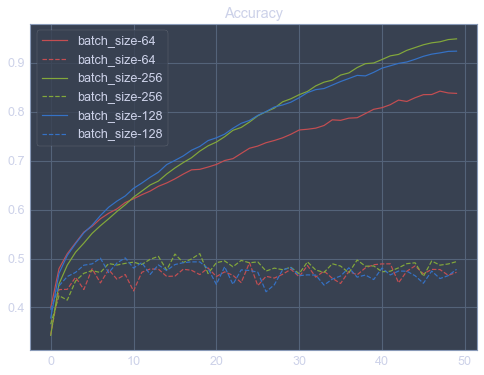

In [21]:
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

fig = plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-loss'])),results2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-loss'])),results2[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()
fig.savefig("BN2_loss.png", bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-acc'])),results2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-acc'])),results2[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
fig.savefig("BN2_acc.png", bbox_inches='tight', dpi=300)

In [20]:
results3 = {}

for batch_size in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "batch_size-%s" % str(batch_size)
    results3[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 150us/step - loss: 1.7333 - acc: 0.3914 - val_loss: 1.6488 - val_acc: 0.4082
Epoch 2/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.5014 - acc: 0.4709 - val_loss: 1.5397 - val_acc: 0.4542
Epoch 3/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.4127 - acc: 0.5006 - val_loss: 1.5364 - val_acc: 0.4584
Epoch 4/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.3478 - acc: 0.5215 - val_loss: 1.4949 - val_acc: 0.4728
Epoch 5/50
50000/50000 [==============================] - 6s 130us/step - loss: 1.2877 - acc: 0.5438 - val_loss: 1.4975 - val_acc: 0.4767
Epoch 6/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.2428 - acc: 0.5611 - val_loss: 1.5124 - val_acc: 0.4633
Epoch 7/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.2070 - acc: 0.5756 - val_loss: 1.4446 - 

50000/50000 [==============================] - 3s 53us/step - loss: 0.8186 - acc: 0.7192 - val_loss: 1.5687 - val_acc: 0.4887
Epoch 19/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7876 - acc: 0.7306 - val_loss: 1.6128 - val_acc: 0.4780
Epoch 20/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.7559 - acc: 0.7419 - val_loss: 1.6399 - val_acc: 0.4820
Epoch 21/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7236 - acc: 0.7545 - val_loss: 1.6314 - val_acc: 0.4742
Epoch 22/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.6926 - acc: 0.7657 - val_loss: 1.8143 - val_acc: 0.4430
Epoch 23/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.6717 - acc: 0.7723 - val_loss: 1.7212 - val_acc: 0.4693
Epoch 24/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.6359 - acc: 0.7877 - val_loss: 1.7403 - val_acc: 0.4779
Epoch 25/50
50000/50000 [=====================

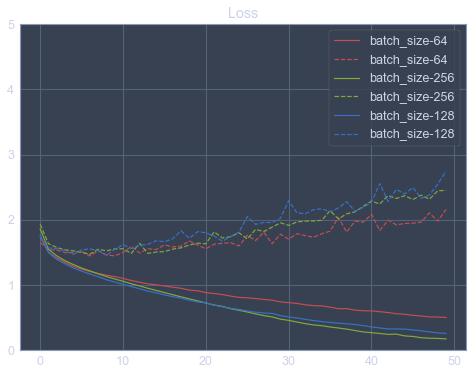

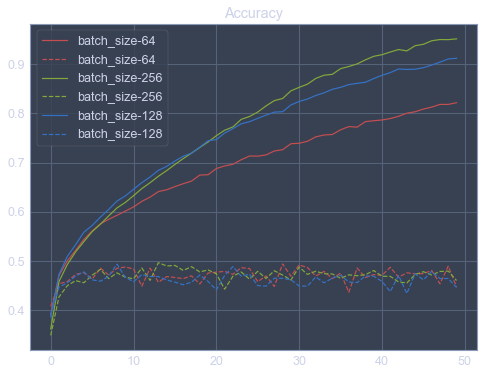

In [22]:
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

fig = plt.figure(figsize=(8,6))
for i, cond in enumerate(results3.keys()):
    plt.plot(range(len(results3[cond]['train-loss'])),results3[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results3[cond]['valid-loss'])),results3[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()
fig.savefig("BN3_loss.png", bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(8,6))
for i, cond in enumerate(results3.keys()):
    plt.plot(range(len(results3[cond]['train-acc'])),results3[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results3[cond]['valid-acc'])),results3[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
fig.savefig("BN3_acc.png", bbox_inches='tight', dpi=300)